In [1]:
import os
import json
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras import backend as K
# print the dir for all the files within the dir
for dirname, dirnames, filenames in os.walk('./'):
    # Remove '.git' from the list of subdirs to avoid walking into it
    if '.git' in dirnames:
        dirnames.remove('.git')
    for filename in filenames:
        print(os.path.join(dirname, filename))

2023-10-27 18:55:19.333437: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-27 18:55:19.334822: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 18:55:19.369603: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 18:55:19.370200: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 18:55:20.021195: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

./README.md
./LICENSE
./sarcasm_detector.ipynb
./data/sarcasm_headlines_dataset_v2.json


### 1) Load the Dataset from .json and split the text and labels

In [2]:
# load the data from the jSON file and split them into sentences and labels
sentences = []
labels = []
with open("./data/sarcasm_headlines_dataset_v2.json", 'r') as f:
    for line in f:
        item = json.loads(line)
        sentences.append(item["headline"])
        labels.append(item["is_sarcastic"])
sentences = np.array(sentences)
labels = np.array(labels)

### 2) What's the percentage of 0 an 1?

- This helps us determine what metrics to use. If one class dominates, the accuracy measures are not representative of the problem and we need to use different metrics such as F1-score, precision, and recall.

/tmp/ipykernel_41742/2146843069.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="is_sarcastic",palette="Set2")


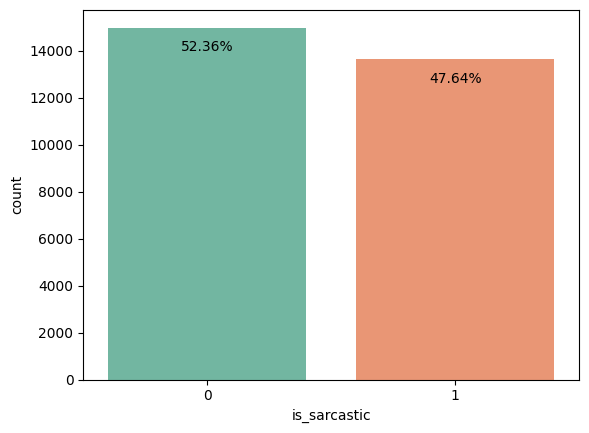

In [3]:
# work with pandas to see if the data is imbalanced or not.
df = pd.read_json("./data/sarcasm_headlines_dataset_v2.json", lines=True)
df.head()
sns.countplot(data=df, x="is_sarcastic",palette="Set2")
ax = plt.gca()
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height - 1000,
            '{:1.2f}%'.format((height / total) * 100),
            ha="center")

### 3) Process the Data

In [4]:
# let's split the data to 86% training and 7% for cv and testing
# reserve some random_state for reproducibility
RAND_STAT = 42
train_sentences, sentences_, train_labels, labels_ = train_test_split(sentences, labels, train_size=0.86, random_state=RAND_STAT)
cv_sentences, test_sentences, cv_labels, test_labels = train_test_split(sentences_, labels_, train_size=0.5, random_state=RAND_STAT)

print('The shape of the training data is: ', train_sentences.shape)
print('The shape of the testing data is: ', test_sentences.shape)
print('The shape of the cross validation data is: ', cv_sentences.shape)

The shape of the training data is:  (24612,)
The shape of the testing data is:  (2004,)
The shape of the cross validation data is:  (2003,)


In [5]:
#model parameters
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# now initiate the tokenizer and tokenize the words
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
print(f'The number of words detected and tokenized: {len(word_index)}')

# let's take the tokens, sequence, and padd them to ensure that all sequences are of the same length
def tokenize_pad_sentence(sentence):
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return sequences, padded

# sequence and pad all sets
train_sentences, train_padded = tokenize_pad_sentence(train_sentences)
cv_sentences, cv_padded = tokenize_pad_sentence(cv_sentences)
test_sentences, test_padded = tokenize_pad_sentence(test_sentences)

The number of words detected and tokenized: 28758


### 4) Building the Model

In [178]:
K.clear_session()
# build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, output_dim=embedding_dim, input_length=max_length), # vectorize each token
    tf.keras.layers.GlobalAveragePooling1D(), # average the vectors
    tf.keras.layers.Dropout(0.3), # dropout to avoid overfitting
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear') # we use a linear activation and use from_logits=True later for numerical stability  
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                        

### 5) Training the model
- After exploring for a bit, I found that the model tends to overfit easily and that 6 epochs is the sweet spot between under- and over-fitting.

In [179]:
num_epochs = 6
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, min_lr=0.001)

history = model.fit(train_padded, train_labels, epochs = num_epochs, 
                    validation_data=(cv_padded, cv_labels), callbacks=[reduce_lr])

Epoch 1/6
770/770 [==============================] - 3s 3ms/step - loss: 0.7177 - accuracy: 0.5233 - val_loss: 0.6640 - val_accuracy: 0.5152 - lr: 0.0010
Epoch 2/6
770/770 [==============================] - 2s 3ms/step - loss: 0.5019 - accuracy: 0.7473 - val_loss: 0.4309 - val_accuracy: 0.8068 - lr: 0.0010
Epoch 3/6
770/770 [==============================] - 2s 3ms/step - loss: 0.3845 - accuracy: 0.8435 - val_loss: 0.3855 - val_accuracy: 0.8318 - lr: 0.0010
Epoch 4/6
770/770 [==============================] - 2s 3ms/step - loss: 0.3314 - accuracy: 0.8701 - val_loss: 0.3652 - val_accuracy: 0.8303 - lr: 0.0010
Epoch 5/6
770/770 [==============================] - 2s 3ms/step - loss: 0.2970 - accuracy: 0.8853 - val_loss: 0.3586 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 6/6
770/770 [==============================] - 2s 3ms/step - loss: 0.2722 - accuracy: 0.8990 - val_loss: 0.3524 - val_accuracy: 0.8607 - lr: 0.0010


### 6) Diagnosis and Evaluation

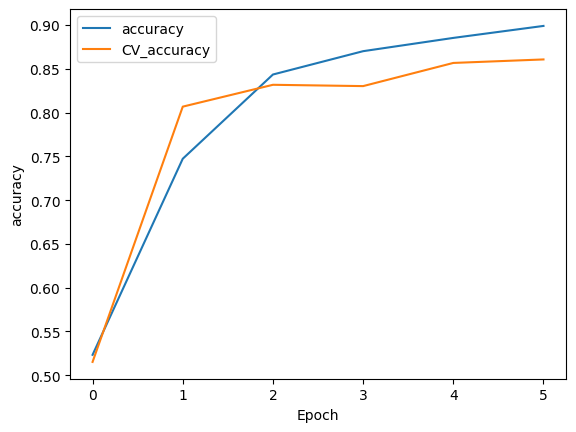

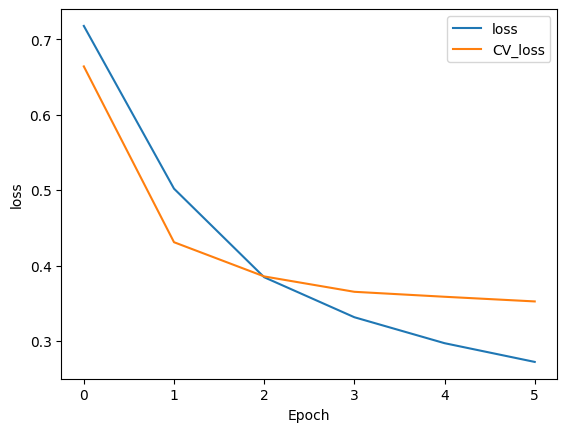

In [180]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epoch')
    plt.ylabel(string)
    plt.legend([string, 'CV_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

- Predicitions and selection of the optimal threshold

63/63 [==============================] - 0s 1ms/step
AUC = 0.9373089894220307


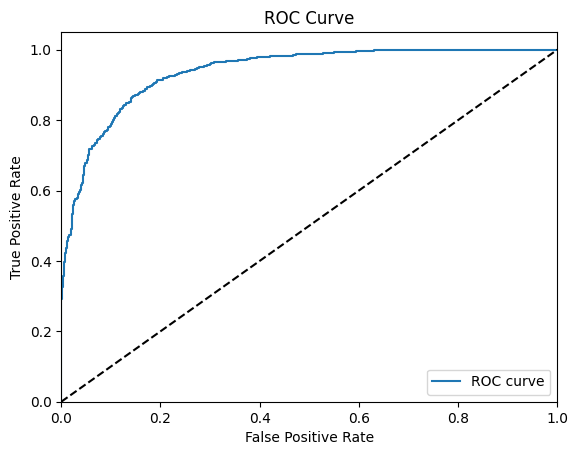

In [181]:
# find the model's predictions
y_pred_probs = tf.keras.activations.sigmoid(model.predict(test_padded)).numpy()

# let's plot the ROC curve to and calculate AUC score
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_probs)
auc = roc_auc_score(test_labels, y_pred_probs)
print (f'AUC = {auc}') 
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [182]:
# given the ROC curve, which F1 score is the best and what recall and precision this corresponds to?
best_threshold = 0
best_f1 = 0
# calculate F1 score for each threshold and find the optimal threshold
for threshold in thresholds:
    y_pred = (y_pred_probs > threshold).astype(int)
    f1 = f1_score(test_labels, y_pred)
    rec = recall_score(test_labels, y_pred)
    acc = accuracy_score(test_labels, y_pred)
    prec = precision_score(test_labels, y_pred, zero_division=1)
    if f1 > best_f1:
        best_f1 = f1
        best_rec = rec
        best_prec = prec
        best_acc = acc
        best_threshold = threshold

print(f"Best Threshold = {best_threshold}")
print(f" --> Best F1 Score = {best_f1}")
print(f" --> Recall = {best_rec}")
print(f" --> Precision = {best_prec}")
print(f" --> Accuracy = {best_acc}")

Best Threshold = 0.3987286388874054
 --> Best F1 Score = 0.8551307847082495
 --> Recall = 0.9129967776584318
 --> Precision = 0.804162724692526
 --> Accuracy = 0.8562874251497006


- Let's test the model on some recent news and some made-up ones for the purpose of testing

In [183]:
# to classify new unseen data, define the following:
def predict_sarcasm(string):
    sentence, padded = tokenize_pad_sentence(string)
    padded = pad_sequences(sentence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    prediction = model.predict(padded)[0][0];
    probability = tf.keras.activations.sigmoid(prediction).numpy()
    print(f'Probability before theorshold: {probability:.2f}')
    if probability >= best_threshold:
        probability = 1.0
        print("Bazinga!")
    else: 
        probability = 0.0
        print("Not sarcastic.")
    return probability

In [184]:
predict_sarcasm("Software Update Fixes Bug, Creates Two More");

2/2 [==============================] - 0s 3ms/step
Probability before theorshold: 0.49
Bazinga!


In [185]:
# misclassification
predict_sarcasm("Woman gets a job she's unqualified for, like men have been doing for centuries");

3/3 [==============================] - 0s 1ms/step
Probability before theorshold: 0.25
Not sarcastic.


In [186]:
predict_sarcasm("Single Woman Finally Works Up Courage To Talk To Cute Guy At Other End Of Horse Costume");

3/3 [==============================] - 0s 2ms/step
Probability before theorshold: 0.49
Bazinga!


In [187]:
predict_sarcasm("Man Always Waits Until Last Minute To Decide What He’ll End Up Sitting Alone In House Dressed As For Halloween")

4/4 [==============================] - 0s 2ms/step
Probability before theorshold: 0.88
Bazinga!


1.0

In [188]:
predict_sarcasm("Florida Students Locked In Decontamination Chamber After Exposure To Book")

3/3 [==============================] - 0s 2ms/step
Probability before theorshold: 0.44
Bazinga!


1.0

In [189]:
predict_sarcasm("Exhausted Doctors Pronounce Patient Dead Enough")

2/2 [==============================] - 0s 2ms/step
Probability before theorshold: 0.60
Bazinga!


1.0

In [190]:
predict_sarcasm("Why the number of sea turtle nests in Florida are exploding, according to experts")

3/3 [==============================] - 0s 2ms/step
Probability before theorshold: 0.25
Not sarcastic.


0.0

In [194]:
predict_sarcasm("Who are the victims of Maine mass shooting? A father and teenage son among the dead")

3/3 [==============================] - 0s 2ms/step
Probability before theorshold: 0.25
Not sarcastic.


0.0

In [196]:
predict_sarcasm("Victims were bowling, playing cornhole when gunman opened fire in Lewiston, Maine")

3/3 [==============================] - 0s 3ms/step
Probability before theorshold: 0.29
Not sarcastic.


0.0